In [298]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from datetime import datetime
import time


In [299]:
ticker = 'HIMS'
start_date = '2023-01-01'
end_date = datetime.now().date()

data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
data.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,HIMS,HIMS,HIMS,HIMS,HIMS,HIMS
Date,,,,,,
2025-06-23,41.980000,41.980000,48.349998,41.970001,48.160000,176087900
2025-06-24,42.950001,42.950001,44.382999,41.840000,42.435001,63586500
2025-06-25,41.410000,41.410000,46.520000,41.200001,43.700001,62880200
2025-06-26,46.279999,46.279999,46.800999,40.880001,41.709999,64363800
2025-06-27,49.410000,49.410000,51.990002,46.400002,47.000000,83285500


In [300]:
data['sma9'] = data['Close'].rolling(window=9).mean()
data['sma21'] = data['Close'].rolling(window=21).mean()

data['Signal'] = 0

data.loc[data['sma9'] > data['sma21'], 'Signal'] = 1
data.loc[data['sma9'] < data['sma21'], 'Signal'] = -1

print(data[['Close', 'sma9', 'sma21', 'Signal']].tail(10))

Price           Close       sma9      sma21 Signal
Ticker           HIMS                             
Date                                              
2025-06-13  55.480000  55.526667  56.442858     -1
2025-06-16  59.779999  56.087778  56.500001     -1
2025-06-17  59.240002  56.713334  56.242382      1
2025-06-18  61.070000  57.635556  56.181905      1
2025-06-20  64.220001  58.512223  56.325239      1
2025-06-23  41.980000  56.858889  55.562382      1
2025-06-24  42.950001  55.492223  55.059048      1
2025-06-25  41.410000  53.697778  54.420001     -1
2025-06-26  46.279999  52.490000  54.082858     -1
2025-06-27  49.410000  51.815556  53.895715     -1


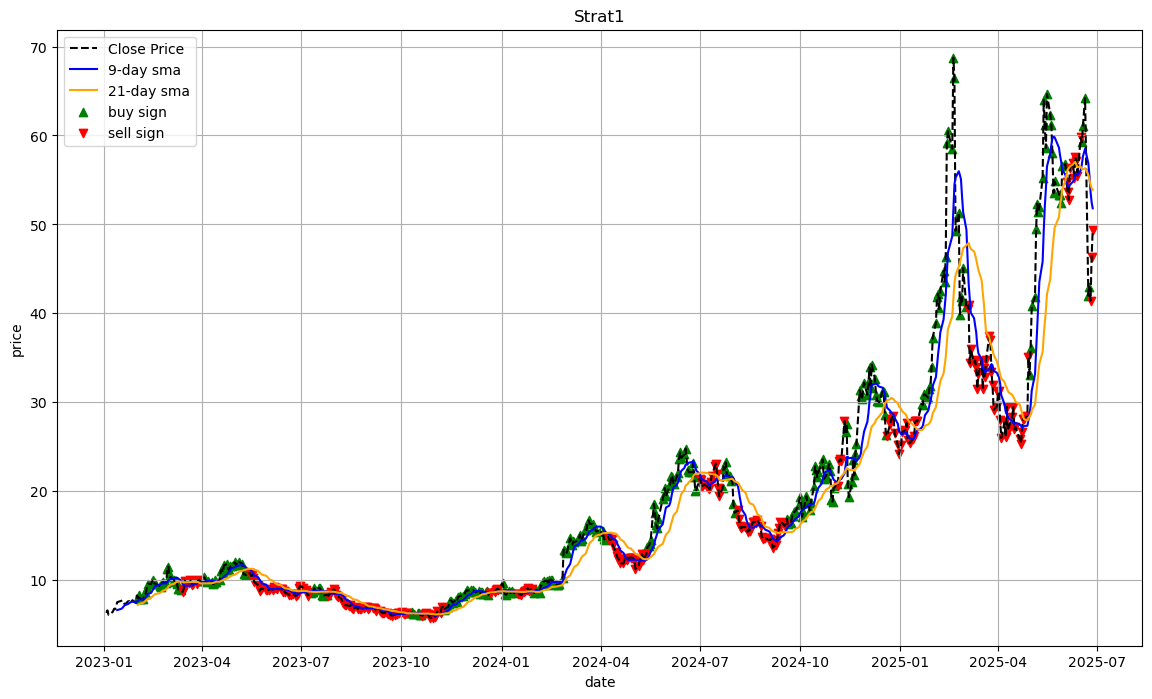

In [301]:
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['Close'], label='Close Price', color='black', linestyle='dashed')
plt.plot(data.index, data['sma9'], label='9-day sma', color='blue')
plt.plot(data.index, data['sma21'], label='21-day sma', color='orange')

buy_signs = data[data['Signal'] == 1]
sell_signs = data[data['Signal'] == -1]

plt.scatter(buy_signs.index, buy_signs['Close'], marker='^', color='green', label='buy sign', alpha=1)
plt.scatter(sell_signs.index, sell_signs['Close'], marker='v', color='red', label='sell sign', alpha=1)

plt.title('Strat1')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.show()

In [302]:
capital = 1
data['DailyReturn'] = data['Close'].pct_change()
data['StratReturn'] = data['Signal'].shift(1) * data['DailyReturn']
data['CumReturn'] = capital * (1 + data['StratReturn']).cumprod()
data.tail()

Price,Adj Close,Close,High,Low,Open,Volume,sma9,sma21,Signal,DailyReturn,StratReturn,CumReturn
Ticker,HIMS,HIMS,HIMS,HIMS,HIMS,HIMS,,,,,,
Date,,,,,,,,,,,,
2025-06-23,41.980000,41.980000,48.349998,41.970001,48.160000,176087900,56.858889,55.562382,1,-0.346310,-0.346310,2.924615
2025-06-24,42.950001,42.950001,44.382999,41.840000,42.435001,63586500,55.492223,55.059048,1,0.023106,0.023106,2.992192
2025-06-25,41.410000,41.410000,46.520000,41.200001,43.700001,62880200,53.697778,54.420001,-1,-0.035856,-0.035856,2.884905
2025-06-26,46.279999,46.279999,46.800999,40.880001,41.709999,64363800,52.490000,54.082858,-1,0.117604,-0.117604,2.545627
2025-06-27,49.410000,49.410000,51.990002,46.400002,47.000000,83285500,51.815556,53.895715,-1,0.067632,-0.067632,2.373462


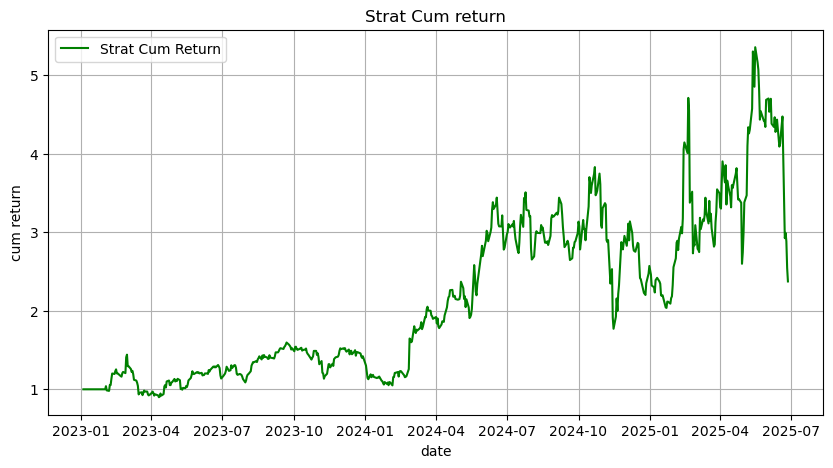

In [303]:
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['CumReturn'], label='Strat Cum Return', color='green')
plt.title('Strat Cum return')
plt.xlabel('date')
plt.ylabel('cum return')
plt.legend()
plt.grid(True)
plt.show()

In [304]:
annualized_return = data['StratReturn'].mean() * 252
print(f'Annualized Return: {annualized_return:.2f}')

annualized_volatility = data['StratReturn'].std() * (252 ** 0.5)
print(f'Annualized Volatility : {annualized_volatility:.2f}')

riskfreerate = 0.1
sharpe_ratio = (annualized_return - riskfreerate) / annualized_volatility
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

cumreturnmax = data['CumReturn'].cummax()
drawdown = (data['CumReturn'] - cumreturnmax) / cumreturnmax
maxdrawdown = drawdown.min()
print(f'Max Drawdown: {maxdrawdown:.2%}')

Annualized Return: 0.74
Annualized Volatility : 0.88
Sharpe ratio: 0.73
Max Drawdown: -55.69%


In [ ]:
API_KEY = 'XXXXXXXXXXXXXXXXX'
SECRET_KEY = 'XXXXXXXXXXXXXXXXX'
BASE_URL = 'https://paper-api.alpaca.markets'

api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

account = api.get_account()
print(account)

In [306]:
quantity = 10
latest_sign = data['Signal'].iloc[-1]

try :
    if (latest_sign == 1) : 
        api.submit_order(symbol=ticker, qty=quantity, side='buy', type='market', time_in_force='gtc')
        print(f'Placed buy order for {ticker}')
    elif (latest_sign == -1) : 
        api.submit_order(symbol=ticker, qty=quantity, side='sell', type='market', time_in_force='gtc')
        print(f'Placed sell order for {ticker}')
    else :
        print(f'No order placed for {ticker}')
except tradeapi.rest.APIError as e:
    print(f"Error Occurred: {e}")
    time.sleep(5)

Placed sell order for HIMS
